# Brug af dictionary metoder og sentiment analyse i Python

## Dictionary metoder i Python

Inden for computationel tekstanalyse, har man længe brugt såkaldte "dictionary metoder" eller "dictionary modeller" (har i øvrigt ikke noget med Python dictionaries at gøre). 

Med tiden er modellerne blevet mere komplekse og sofistikerede, men i deres mest basale form, er det blot modeller, der tildeler en stykke tekst en score baseret ud fra en række prædefinerede ord (en "dictionary"). 

Man kan finde forskellige pakker med prædefinerede dictionary modeller (fx til sentiment analysis), men man kan også lave sine egne.

Herunder ses to eksempler på en dictionary-tilgang med basis Python funktionalitet.

### Simpel dictionary

Herunder et eksempel med en simpel dictionary, der blot optæller, hvor mange gange visse ord optræder i hver tekst.

Der bruges en række nyheder/blogindlæg fra [sf.dk](https://sf.dk/) som eksempeldata (hentet efteråret 2022).

In [1]:
# indlæs pakker

import os
from os.path import join
import re
import pandas as pd

In [2]:
# indlæs data

data_p = 'C:/Users/kgk/OneDrive - Aalborg Universitet/Undervisning/E23/sds_2023/datasets/polparties'

# sf texts
sf_texts = []

sf_files = os.listdir(join(data_p, 'sf'))

for filename in sf_files:
    textfile = join(data_p, 'sf', filename)
    text = open(textfile, 'r', encoding = 'utf-8').read()
    
    sf_texts.append(text)    

In [3]:
# definér keywords ("ordbog")

keywords = ['skat', 'finans', 'økonomi', 'penge']

In [4]:
# simpel funktion der scorer tekst baseret på keywords optræden

def simple_dict(text, keywords = keywords):

    score = 0

    text_lower = text.lower()
    
    for keyword in keywords:
        word_as_regex = re.compile(keyword)
        
        n_found = len(word_as_regex.findall(text_lower))

        score = score + n_found

    return(score)

In [5]:
# brug funktion på første 10 tekster

for text in sf_texts[0:10]:

    print(simple_dict(text))

5
1
4
1
3
3
9
0
0
2


In [6]:
# konvertér til pandas series
texts_series = pd.Series(sf_texts)

# brug funtkion på series af tekster
scores_series = texts_series.apply(simple_dict)

<Axes: ylabel='Frequency'>

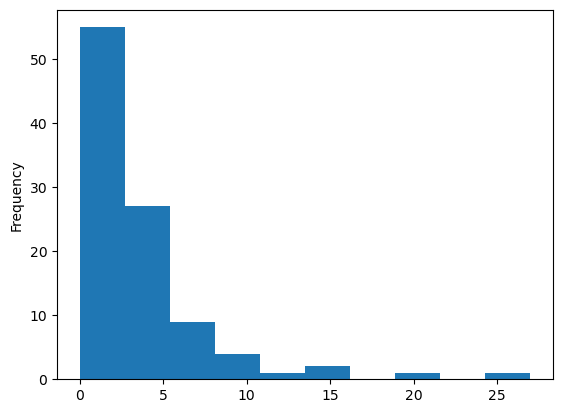

In [7]:
# histogram af scores
scores_series.plot.hist()

### Vægtet dictionary

I nedenstående ses eksempel på brug af en vægtet dictionary, hvor hvert nøgleord gives en score. Igen bruges SF-teksterne som eksempeldata.

In [8]:
# scored keywords

scored_keywords = {
    'skat': 3, 
    'finans': 3, 
    'økonomi': 2, 
    'penge': 1
}

In [9]:
# dictionary funktion der scorer tekster pba. keywords og deres scores

def scored_dict(text, keywords = scored_keywords):

    score = 0

    text_lower = text.lower()
    
    for keyword, weight in keywords.items():
        word_as_regex = re.compile(keyword)
        
        n_found = len(word_as_regex.findall(text_lower))

        n_weighted = n_found * weight # gang antal fundne ord med score for nøgleord (vægt)
        
        score = score + n_weighted # opdater score

    return(score)

In [10]:
# konvertér til pandas series
texts_series = pd.Series(sf_texts)

# brug funtkion på series af tekster
scores_series = texts_series.apply(scored_dict)

<Axes: ylabel='Frequency'>

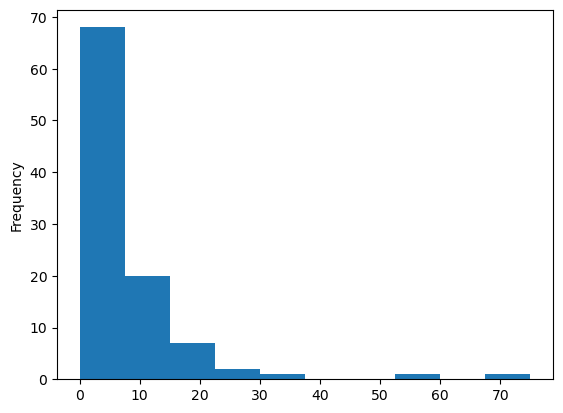

In [11]:
# histogram af scores
scores_series.plot.hist()

## Sentiment analyse med `asent` i Python

I denne notebook vises, hvordan man kan udføre sentiment analyse i Python.

Der bruges pakken [`asent`](https://kennethenevoldsen.github.io/asent/installation.html), som virker sammen med `spaCy` til at udføre sentiment analyse.


## Hvad er asent?

`asent` er en regel-baseret sentiment model, der bygger på en dictionary af ord, som er kategoriseret som hhv. positive og negative ord. Ordene er samtidig givet en polaritetsscore for, hvor positive og negative de er.

Modellen virker ved, at den sammenholder ord i et stykke tekst med ordene i dictionary og giver tekststykket en samlet polaritetsscore for, hvor positivt eller negativt det er.


### Lexicon

Da `asent` er en dictionary-model, skal den bruge en oversigt over ord samt deres tilknyttede score (kaldes ofte "lexicon"). De lexicons, som asent bruger, kan findes på pakkens github-repository: [https://github.com/KennethEnevoldsen/asent/tree/main/src/asent/lexicons](https://github.com/KennethEnevoldsen/asent/tree/main/src/asent/lexicons).

*Bemærk:* `asent` genbruger lexicons fra andre sentiment modeller ([afinn](https://github.com/fnielsen/afinn) og [sentida](https://github.com/Guscode/Sentida)).


### asent i kombination med `spaCy` 

`asent` virker i kombination med en `spaCy` sprogmodel/pipeline. På den måde kan modellen tage højde for sætningskonstruktion og negationer (fx "ikke glad") for at udregne mere præcise polaritetsscores.

`spaCy` modeller er altid et *pipeline*:

![pipeline](https://spacy.io/images/pipeline-design.svg)

Det betyder, at når et stykke tekst behandles med `spaCy` (fx `doc = nlp(text)`), så tages tekststykket igennem flere processer (tokenizer, part-of-speech tagger, dependency parser osv.) - ligesom et samlebånd på en fabrik. 

Man kan altid tilføje flere led i et `spaCy` pipeline - altså endnu en ting, som teksten skal igennem på samlebåndet. Det er den måde, som man bruger `asent`, da den skal bruge information tidligere i pipelinet for at udføre sentiment analysen af teksten. 

Resultatet af sentiment analysen for tekststykket tilgås som attributes for doc-objektet (som man ellers tilgår attributes fra et `spaCy` doc-objekt).


## Dictionary modeller vs. trænede modeller (neurale netværk, transformers etc.)

Dictionary modeller (herunder modeller til sentiment analyse) er efterhånden overgået af præ-trænede maskinlæringsmodeller baseret på transformers eller anden neural netværksarkitektur. Fordelene ved en dictionary model er dog, at det altid er fuldstændig gennemskueligt, hvorfor modellen har analyseret teksten, som den har. Præ-trænede modeller er efterhånden mere nøjagtige, men det er meget vanskeligere for os at spørge modellen, hvorfor den har nået frem til et specifikt resultat ("black-box").

## Brug af `asent`

I det følgende vises, hvordan `asent` bruges på dansk på enkelte tekststykker:

In [12]:
# indlæser pakker
import spacy
import asent

#python -m spacy download da_core_news_lg

# indlæs spacy sprogmodel og pipeline
nlp = spacy.load('da_core_news_lg') # sprogmodel skal være hentet inden, at den kan indlæses

# tilføj sentiment model til pipeline
nlp.add_pipe('asent_da_v1')

`asent` er nu en del af et `spaCy` pipeline (lagret i `nlp`). Vi er nu klar til at analysere et stykke tekst:

In [13]:
text = "Jeg kan lide grøn peber på varm leverpostej"

doc = nlp(text)

Blot at køre teksten gennem pipeline giver ikke noget output, men alle de dele, som er blevet anlayseret og tilføjet teksten på samlebåndet (pipeline), kan nu tilgås i doc-objektet.

`asent` giver ikke blot én samlet score for hele teksten, men analyserer i stedet sætninger:

In [14]:
for sentence in doc.sents:
    print(sentence._.polarity)

neg=0.0 neu=0.6 pos=0.4 compound=0.4588 span=Jeg kan lide grøn peber på varm leverpostej


`asent` tildeler både en score for hhv. negativ (`neg`), neutralt (`neu`) og positivt (`pos`). Derudover gives et samlet mål for polaritet (`compound`). Alle scores er normaliseret og rangerer fra -1 til 1. En `compound` score over 0 indikerer derfor overvejende positiv sætning, og under 0 en overvejende negativ sætning.

Denne sætning vurderes overvejende positivt (0.4588). 

### Polaritet på token-niveau

Vi kan inspicere resultatet yderligere ved at se, hvordan de enkelte ord/tokens er vurderet:

In [15]:
for token in doc:
    print(token._.polarity)

polarity=0.0 token=Jeg span=Jeg
polarity=0.0 token=kan span=kan
polarity=1.0 token=lide span=lide
polarity=0.0 token=grøn span=grøn
polarity=0.0 token=peber span=peber
polarity=0.0 token=på span=på
polarity=1.0 token=varm span=varm
polarity=0.0 token=leverpostej span=leverpostej


Her ses at ordene "lide" og "varm" vurderes positive (polarity > 0).

`polarity` scores er ikke normaliseret, men er omregninger af de oprindelige tildelte værdier for ordene. De oprindelige tildelte værdier omtales deres "valence" og kan ligeledes tilgås:

In [16]:
for token in doc:
    print(token, "\t", token._.valence)

Jeg 	 0.0
kan 	 0.0
lide 	 1.0
grøn 	 0.0
peber 	 0.0
på 	 0.0
varm 	 1.0
leverpostej 	 0.0


Her er der ingen forskel mellem valence og polarity for ordene. Dette fordi at sætningskonstruktionen ikke lægger op til, at ordene skal vægtes anderledes (se andet eksempel længere nede).

### Visualisering af udregning

`asent` indeholder også visualiseringsfunktioner til at inspicere sentiment analysen:

In [17]:
asent.visualize(doc, style="prediction")

In [18]:
asent.visualize(doc, style="analysis")

### Negation og tekster med flere udtryk

Da `asent` benytter `spaCy` pipeline, kan den tage højde for sætningskonstruktion. I det nedenstående bruges `asent` på en sætning med negation og flere udtryk:

In [19]:
text = "Jeg kan ikke lide grøn peber på varm leverpostej. Jeg kan bedre lide rød peber."

doc = nlp(text)

In [20]:
asent.visualize(doc, style="prediction")

Her ses hvordan `asent` behandler ordet "lide" forskelligt alt efter kontekst. Da det negeres i første sætning, tildeles det en negativ polaritet.

In [21]:
asent.visualize(doc[:9], style="analysis")

In [22]:
asent.visualize(doc[10:], style="analysis")

In [23]:
for sentence in doc.sents:
    print(sentence._.polarity)

neg=0.148 neu=0.681 pos=0.17 compound=0.067 span=Jeg kan ikke lide grøn peber på varm leverpostej.
neg=0.0 neu=0.5 pos=0.5 compound=0.6124 span=Jeg kan bedre lide rød peber.
